In [7]:
# Import Packages and setup
import logging
import os

import numpy as np

import scarlet
import scarlet.display

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
# use a better colormap and don't interpolate the pixels
matplotlib.rc('image', cmap='inferno')
matplotlib.rc('image', interpolation='none')

%load_ext snakeviz

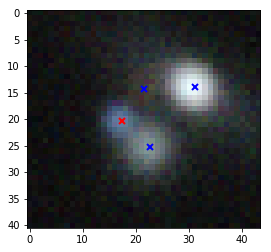

In [2]:
idx = 4
datapath = "/Users/fmoolekamp/data/testdata_deblender/sim_data/unmatched_sim"
#datapath = "/Users/fmoolekamp/data/testdata_deblender/sim_data/psf_matched_sim"
psfs = np.load(os.path.join(datapath, "psfs.npz"))["psfs"]
data = np.load(os.path.join(datapath, "images_{0}.npz".format(idx)))
images = data["images"]
filters = data["filters"]

from astropy.table import Table as ApTable
catalog = ApTable.read(os.path.join(datapath, "true_catalog_{0}.fits".format(idx)))
# Only use a single component for each source
catalog = catalog[catalog["component"]!="disk"]
bg_rms = np.array([20]*len(images))

# display psfs
#plt.imshow(psfs[0])
#plt.show()

# Use Asinh scaling for the images
norm = scarlet.display.Asinh(img=images, Q=20)
# Map i,r,g -> RGB
filter_indices = [3,2,1]
# Convert the image to an RGB image
img_rgb = scarlet.display.img_to_rgb(images, filter_indices=filter_indices, norm=norm)
plt.imshow(img_rgb)
for src in catalog:
    if src["is_star"]:
        plt.plot(src["x"], src["y"], "rx", mew=2)
    else:
        plt.plot(src["x"], src["y"], "bx", mew=2)
plt.show()

In [3]:
%%time
# Fit the psfs
target_psf = scarlet.psf_match.fit_target_psf(psfs, scarlet.psf_match.moffat)
#plt.imshow(target_psf,norm=scarlet.display.Asinh(img=target_psf))
#plt.show()
diff_kernels, psf_blend = scarlet.psf_match.build_diff_kernels(psfs, target_psf)

CPU times: user 3.67 s, sys: 23 ms, total: 3.7 s
Wall time: 1.21 s


In [8]:
%%snakeviz
from scarlet.config import Normalization
config = scarlet.config.Config(update_order=[0,1], accelerated=True, refine_skip=2, normalization=Normalization.S,
                               update_model=True)
sources = [
    #scarlet.ExtendedSource((src['y'],src['x']), images, bg_rms, psf=diff_kernels, config=config)
    scarlet.ExtendedSource((src['y'],src['x']), images, bg_rms, config=config)
    for src in catalog
]

blend = scarlet.Blend(sources)
blend.set_data(images, bg_rms=bg_rms, config=config)
blend.fit(100)

 
*** Profile stats marshalled to file '/var/folders/38/bmpb2s492vl_wypckg477jkr0000gn/T/tmpxeu4u5yk'. 


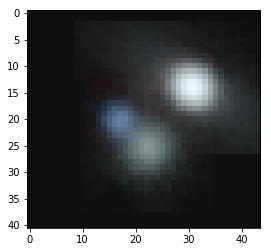

58
44520.09533046184


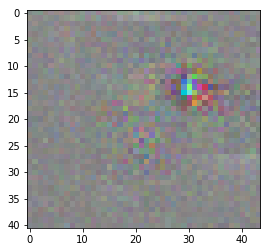

In [26]:
from scarlet.config import Normalization

config = scarlet.config.Config(update_order=[0,1], accelerated=True, refine_skip=2, normalization=Normalization.S,
                               update_model=True)
sources = [
    #scarlet.ExtendedSource((src['y'],src['x']), images, bg_rms, psf=diff_kernels, config=config)
    scarlet.ExtendedSource((src['y'],src['x']), images, bg_rms, config=config)
    for src in catalog
]

blend = scarlet.Blend(sources)
blend.set_data(images, bg_rms=bg_rms, config=config)
blend.fit(100)

model = blend.get_model()
img_rgb = scarlet.display.img_to_rgb(model, filter_indices=[3,2,1], norm=norm)
plt.imshow(img_rgb)
plt.show()
print(blend.it)
residual = images-model
img_rgb = scarlet.display.img_to_rgb(residual, filter_indices=filter_indices)
plt.imshow(img_rgb)
print(np.sum(np.abs(residual)))

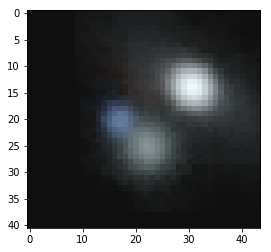

100
43003.67162661441


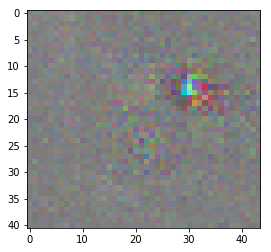

In [24]:
config = scarlet.config.Config(update_order=[1,0], accelerated=True, refine_skip=2)
sources = [
    #scarlet.ExtendedSource((src['y'],src['x']), images, bg_rms, psf=diff_kernels, config=config)
    scarlet.ExtendedSource((src['y'],src['x']), images, bg_rms, config=config)
    for src in catalog
]

blend = scarlet.Blend(sources)
blend.set_data(images, bg_rms=bg_rms, config=config)
blend.fit(100)

model = blend.get_model()
img_rgb = scarlet.display.img_to_rgb(model, filter_indices=[3,2,1], norm=norm)
plt.imshow(img_rgb)
plt.show()
print(blend.it)
residual = images-model
img_rgb = scarlet.display.img_to_rgb(residual, filter_indices=filter_indices)
plt.imshow(img_rgb)
print(np.sum(np.abs(residual)))

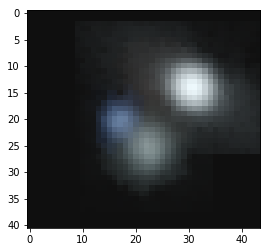

20
46360.4867848038


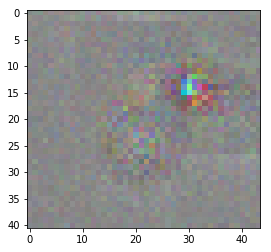

In [25]:
from scarlet.config import Normalization

config = scarlet.config.Config(update_order=[0,1], accelerated=False, refine_skip=2, normalization=Normalization.Smax,
                               update_model=True)
sources = [
    #scarlet.ExtendedSource((src['y'],src['x']), images, bg_rms, psf=diff_kernels, config=config)
    scarlet.ExtendedSource((src['y'],src['x']), images, bg_rms, config=config)
    for src in catalog
]

blend = scarlet.Blend(sources)
blend.set_data(images, bg_rms=bg_rms, config=config)
blend.fit(100)

model = blend.get_model()
img_rgb = scarlet.display.img_to_rgb(model, filter_indices=[3,2,1], norm=norm)
plt.imshow(img_rgb)
plt.show()
print(blend.it)
residual = images-model
img_rgb = scarlet.display.img_to_rgb(residual, filter_indices=filter_indices)
plt.imshow(img_rgb)
print(np.sum(np.abs(residual)))

In [27]:
import scarlet.constraint as sc

config = scarlet.config.Config(refine_skip=2, accelerated=False, normalization=Normalization.S)

constraints = (
    sc.SimpleConstraint(config.normalization)
)

sources = [
    scarlet.PointSource((src['y'],src['x']), images, constraints=constraints, psf=psfs, shape=psfs[0].shape, fix_morph=True, config=config)
    for src in catalog
]

blend = scarlet.Blend(sources)
blend.set_data(images, bg_rms=bg_rms, config=config)

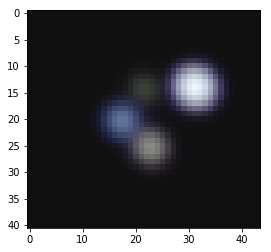

In [28]:
model = blend.get_model()
img_rgb = scarlet.display.img_to_rgb(model, filter_indices=[3,2,1], norm=norm)
plt.imshow(img_rgb)
plt.show()

4


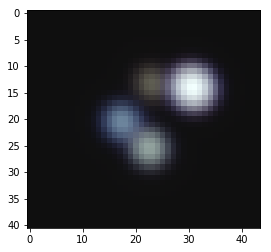

In [29]:
blend.fit(100)
print(blend.it)
model = blend.get_model()
img_rgb = scarlet.display.img_to_rgb(model, filter_indices=[3,2,1], norm=norm)
plt.imshow(img_rgb)
plt.show()

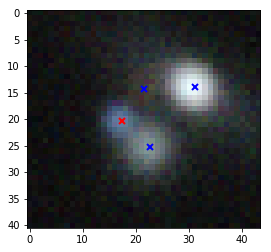

In [30]:
img_rgb = scarlet.display.img_to_rgb(images, filter_indices=filter_indices, norm=norm)
plt.imshow(img_rgb)
for src in catalog:
    if src["is_star"]:
        plt.plot(src["x"], src["y"], "rx", mew=2)
    else:
        plt.plot(src["x"], src["y"], "bx", mew=2)
plt.show()

84543.87722255097


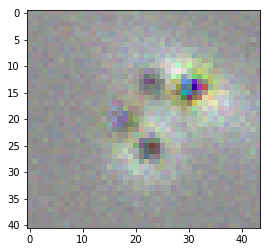

In [31]:
residual = images-model
img_rgb = scarlet.display.img_to_rgb(residual, filter_indices=filter_indices)
plt.imshow(img_rgb)
print(np.sum(np.abs(residual)))